In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

from params import *

from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

env = gym.make(envs[env_to_use]).unwrapped
if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
    

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_num = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
input_num = output_num*2


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
def evolve(population,population_out_size,gen,p_fitness,mutation_rate,mutation_scale,lr):
    #Chose creatures based on fitness
    sort = np.argsort(np.max(p_fitness)-p_fitness)
    p_exp = population_exponent
    if population_exponent <= 0:
        p_exp = population_out_size
        
    choice = []
    for i in range(population_out_size+1):
        ex = (population_out_size)/p_exp#population_out_size
        ex = math.ceil(ex**(1/(i+1)))
        for _ in range(int(ex)):
            choice.append(sort[i%(len(p_fitness)-1)])
        if len(choice) > population_out_size+1:
            choice = choice[:population_out_size+1]
            break
    np.random.shuffle(choice)
    
    #mate and mutate creatures
    new_population = []
    for p in range(population_out_size):
        #Pick parents
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        
        child = mate(env,creature_out_size,lr[p],device,first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    return new_population

In [3]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    gen_explore_all = []
    gen_exploit_all = []
    dis_loss_all = []
    dis_confidence_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        for i in range(len(population)//batch_size):
            
            #turn population into vectors
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            dis_out_r,_ = dis(real_batch)
            dis_out_r = dis_out_r.squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = (torch.pow((dis_out_r[...,0]-rank),2))
            
            dis_error_real_mean = torch.mean(dis_error_real)
            dis_error_real_mean.backward(retain_graph=True)
            
            #discriminator confidence in its prediction
            dis_confidence = torch.mean(torch.pow(dis_out_r[...,1]-dis_error_real.detach(),2))
            dis_confidence.backward()
            
            dis_optimizer.step() 
            dis_loss_all.append(dis_error_real_mean)  
            dis_confidence_all.append(dis_confidence)
            
        #if False:
        #for i in range(len(population)//batch_size):
            #generate children from population
            gen_optimizer.zero_grad()
            mutation = torch.from_numpy(np.random.uniform(all_a,all_a,batch_size)).type('torch.FloatTensor').to(device)
            
            child,confidence = gen_children(population,device,gen,batch_size,a = mutation)
            #train discriminator
            dis_out_f,dis_out_last = dis(child)
            dis_out_f = dis_out_f.squeeze(-1)
            
            
            
            #define generator loss
            #variety = -torch.std(dis_out_f[...,0])#-torch.mean(torch.std(dis_out_last,-1))
            probs = torch.softmax(dis_out_f[...,0],-1)
            variety = -(torch.sum(probs*torch.log(probs),-1)) * 0.1
            
            gen_error_exploration =  (variety)-torch.mean(dis_out_f[...,1])
            gen_error_exploitation = -torch.mean(dis_out_f[...,0]) 
            gen_error =  gen_error_exploitation + (gen_error_exploration)
            
            gen_error.backward()
            gen_optimizer.step() 
            gen.hidden = None
            #keep losses to draw graph 
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            
            
    #print(rank)
    #print(dis_out_r[...,0])
    #print(confidence)
    #print(get_params(population[0]))
    #print()
            
    return gen_explore_all,gen_exploit_all, dis_loss_all,dis_confidence_all


starting training
740
Measured population fitness : 6s
population fitness : [ -27.17257187  -21.91638882  -47.87935405  -62.78602109  -93.31076752
  -36.34509654 -101.5956928   -94.34170503 -104.65286877  -42.64460114]
mean fit : -63.26450676323848
Trained GAN : 3s
Evolved : 0s


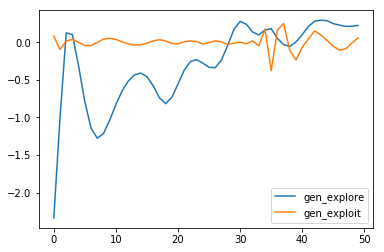

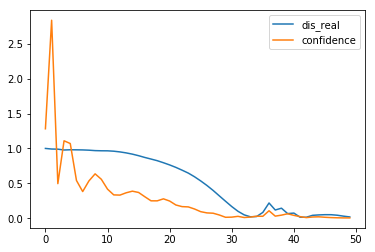

Generation 1  fitness : -21.91638881604678
#################################
Measured population fitness : 5s
population fitness : [ -95.06433398  -96.04829571  -38.78534549  -23.93864475 -111.6860752
  -96.57397833  -48.56541797 -114.42307662  -25.02314772  -17.10716701]
mean fit : -66.72154827781196
Trained GAN : 6s
Evolved : 0s


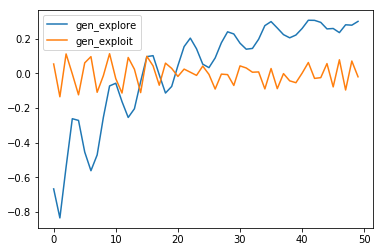

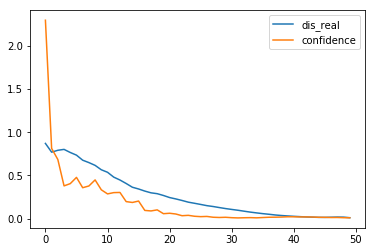

Generation 2  fitness : -17.107167011493225
#################################
Measured population fitness : 4s
population fitness : [-122.59314922  -96.75619667  -94.87979396  -30.17751864  -93.91128676
 -111.43686942  -19.27034317  -84.37231098 -112.45848911  -35.94098979]
mean fit : -80.17969477100256
Trained GAN : 6s
Evolved : 0s


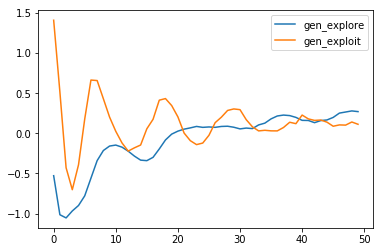

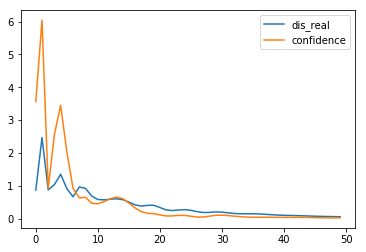

Generation 3  fitness : -19.27034316510922
#################################
Measured population fitness : 3s
population fitness : [-102.01554446  -94.59952354  -93.51096951  -30.7806421  -103.14617525
  -42.3561723  -101.39537032 -121.89343261  -23.45944358  -96.61287807]
mean fit : -80.97701517389444
Trained GAN : 6s
Evolved : 0s


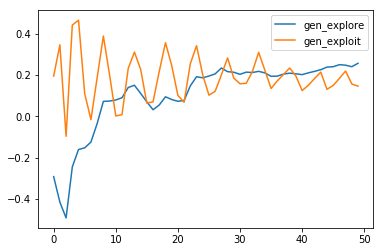

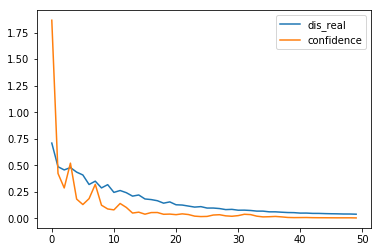

Generation 4  fitness : -23.459443579907468
#################################
Measured population fitness : 5s
population fitness : [ -45.56275672 -111.47494186 -113.40264863  -48.72626038  -94.36354022
  -25.96026528  -23.29945535  -93.99722888  -40.57139841  -94.80361824]
mean fit : -69.21621139614761
Trained GAN : 6s
Evolved : 0s


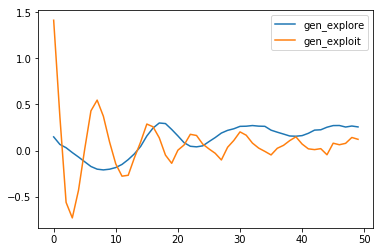

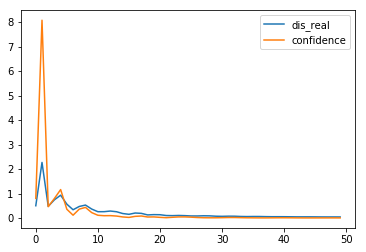

Generation 5  fitness : -23.29945534522792
#################################
Measured population fitness : 3s
population fitness : [ -94.18806689  -94.07740498 -102.72125058  -25.94717699  -94.28429326
 -113.10141366  -38.76162028 -101.02808752  -39.68560915 -111.64598577]
mean fit : -81.54409090655426
Trained GAN : 6s
Evolved : 0s


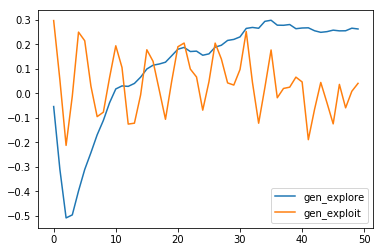

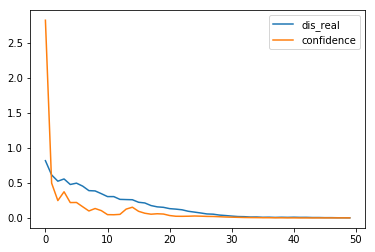

Generation 6  fitness : -25.947176985134643
#################################
Measured population fitness : 3s
population fitness : [ -92.8688512  -101.4954698  -111.12385264  -52.56815565  -38.27389286
  -96.02658152  -95.55494385  -35.5611336  -112.45650445 -111.91400205]
mean fit : -84.78433876191623
Trained GAN : 6s
Evolved : 0s


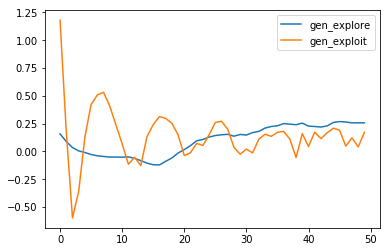

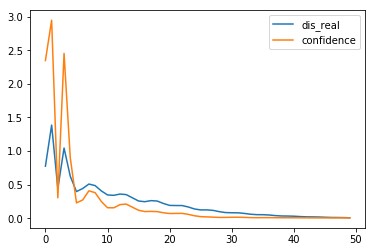

Generation 7  fitness : -35.56113360439474
#################################
Measured population fitness : 4s
population fitness : [ -39.13780952  -97.33864153  -34.70028282  -99.47302351  -92.21637932
  -94.75449049 -118.92989129  -91.31057561  -27.41882248  -24.65512127]
mean fit : -71.99350378417955
Trained GAN : 5s
Evolved : 0s


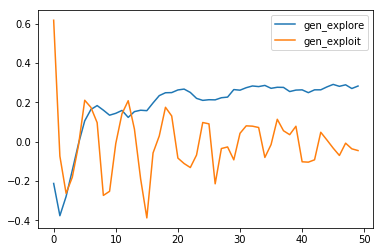

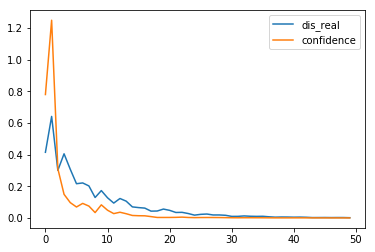

Generation 8  fitness : -24.655121273760308
#################################
Measured population fitness : 8s
population fitness : [-31.92507551 -28.99932121 -35.18418899 -95.16905005 -43.31062515
 -50.20894287 -27.34426346 -40.82631308 -97.49286285 -51.14940686]
mean fit : -50.161005002635974
Trained GAN : 5s
Evolved : 0s


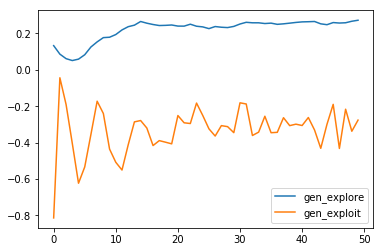

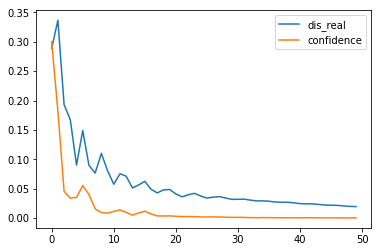

Generation 9  fitness : -27.344263463441674
#################################
Measured population fitness : 7s
population fitness : [ -25.43877057  -97.55853066  -20.57677864  -24.45933422  -50.02434771
  -48.98211978 -113.34178364  -28.04545406 -100.44732408  -40.10601922]
mean fit : -54.89804625880023
Trained GAN : 6s
Evolved : 0s


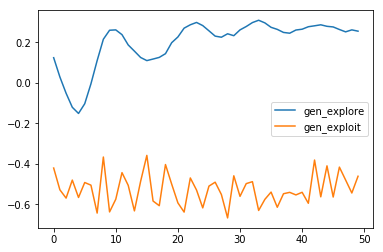

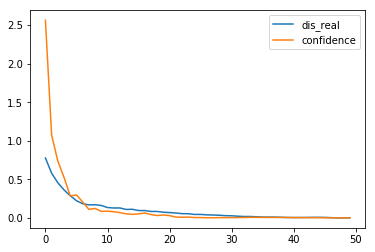

Generation 10  fitness : -20.576778644387208
#################################
Measured population fitness : 6s
population fitness : [  -8.59846825  -97.1636547   -57.33542847  -28.0014357   -28.77440758
 -101.45963274  -49.95173774 -114.39538754  -24.81897732  -96.07295212]
mean fit : -60.65720821600047
Trained GAN : 6s
Evolved : 0s


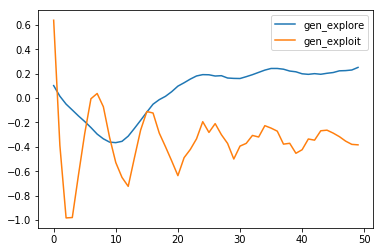

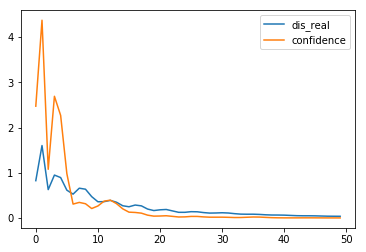

Generation 11  fitness : -8.598468251746695
#################################
Measured population fitness : 5s
population fitness : [-116.15591728  -39.4625227  -118.69929929 -110.12512599  -42.02773431
  -35.26133366 -105.73169829  -28.50182779 -112.20405139  -34.6100398 ]
mean fit : -74.27795505033933
Trained GAN : 6s
Evolved : 0s


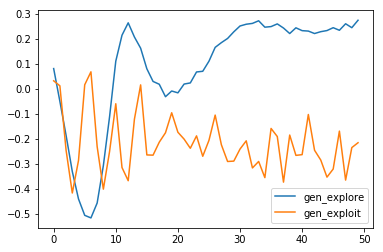

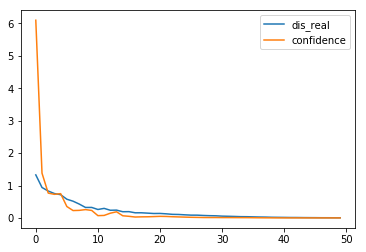

Generation 12  fitness : -28.501827793812446
#################################
Measured population fitness : 5s
population fitness : [ -93.54687087  -33.75925884 -111.18534274  -94.98964323  -13.83896704
  -28.6945984   -96.50651828  -19.5053169   -98.70100506  -19.46371056]
mean fit : -61.01912319210705
Trained GAN : 5s
Evolved : 0s


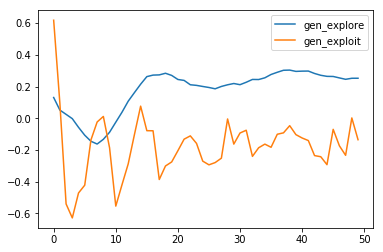

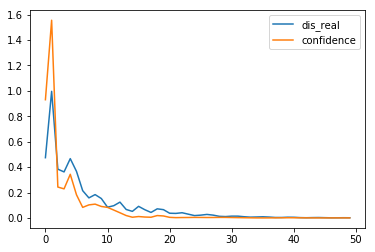

Generation 13  fitness : -13.838967041070202
#################################
Measured population fitness : 4s
population fitness : [ -93.41238964  -93.68335679 -113.80303217  -43.30257388  -40.4610298
  -33.34653406  -93.59146861 -112.5261622   -38.11312329  -93.31943031]
mean fit : -75.55591007496405
Trained GAN : 5s
Evolved : 0s


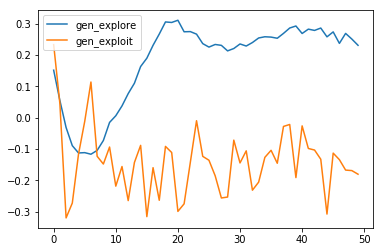

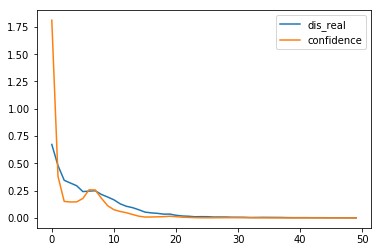

Generation 14  fitness : -33.346534062469104
#################################
Measured population fitness : 3s
population fitness : [ -93.59454153 -113.2007483  -116.42906137  -95.57606713  -96.80274709
  -36.91372164  -32.79957449 -111.32681549  -12.16116774  -95.21338556]
mean fit : -80.40178303367087
Trained GAN : 5s
Evolved : 0s


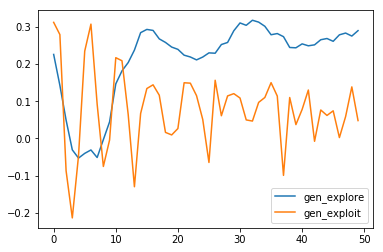

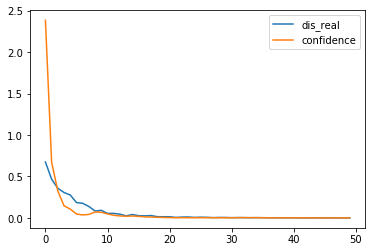

Generation 15  fitness : -12.161167737721183
#################################
Measured population fitness : 5s
population fitness : [-110.67335757  -35.56569024   -8.81464791  -94.03233246  -97.16898242
  -99.46918545  -64.86813326  -35.35896328 -119.93525425  -28.04714921]
mean fit : -69.39336960445637
Trained GAN : 6s
Evolved : 0s


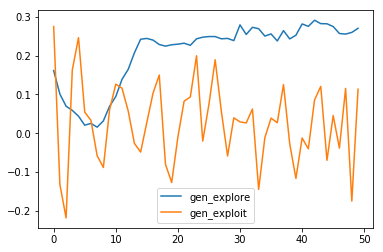

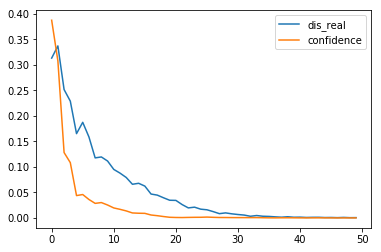

Generation 16  fitness : -8.814647913476481
#################################
Measured population fitness : 4s
population fitness : [ -93.33608373 -100.35538414  -97.72811273  -49.14387585 -112.02057873
  -21.61032114  -54.23367081 -100.91931282  -93.17504566   -9.16206891]
mean fit : -73.16844545382992
Trained GAN : 6s
Evolved : 0s


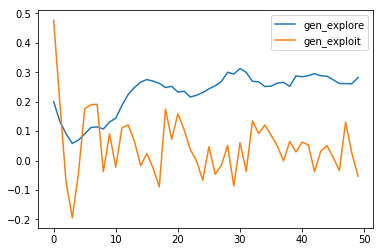

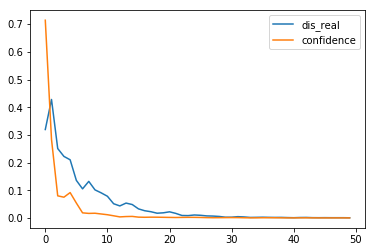

Generation 17  fitness : -9.162068910741631
#################################
Measured population fitness : 4s
population fitness : [ -99.98458145  -23.3438308  -107.66824009 -113.21246751  -96.41461388
  -33.2710742   -98.58120777  -24.75011193  -94.93517512  -53.52569491]
mean fit : -74.56869976436982
Trained GAN : 6s
Evolved : 0s


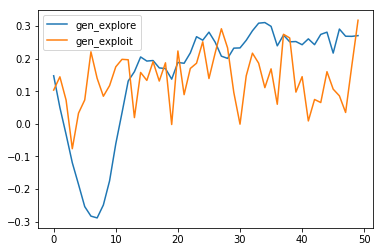

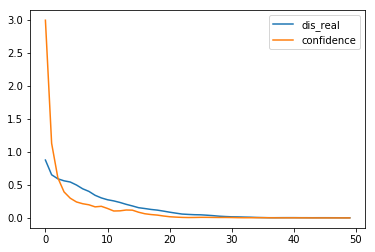

Generation 18  fitness : -23.343830797524898
#################################
Measured population fitness : 4s
population fitness : [ -35.54689793  -11.4312856   -94.16556986 -100.78757014  -94.88423584
 -103.21945686  -25.03547893  -35.19693141  -99.20859597  -96.0353155 ]
mean fit : -69.55113380626536
Trained GAN : 6s
Evolved : 0s


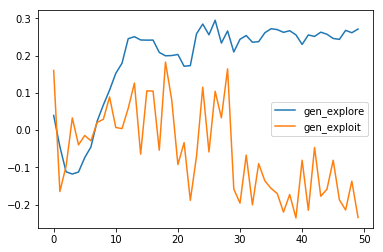

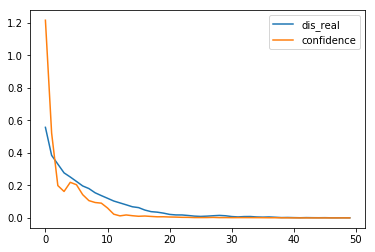

Generation 19  fitness : -11.43128560408666
#################################


KeyboardInterrupt: 

In [4]:
#population_size = 10
#max_population = population_size
#max_population_batch = 2
#out_size = population_size
#n_generations = 300

#randomly inititialise starting population
population = []

for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
    
    #pars = torch.from_numpy(np.random.uniform(0,1,get_params(creat).numel())).type('torch.FloatTensor').to(device)
    pars = torch.tanh(get_params(creat))
    creat = set_params(creat,pars)
    population.append(creat)


print("starting training")
print(len(get_params(Creature(env.observation_space.shape[0],creature_out_size))))

old_population = []
old_fitnesses = []
all_fitnesses = []
gen = Generator(input_num,output_num,device).to(device)
dis = Discriminator().to(device)

for i in range(n_generations):
    start_time = time.time()
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.001,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.001,betas=(0.9,0.999))
   
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    all_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    #if len(all_fitnesses) > 5:
    #    all_fitnesses.pop(0)
        
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))

    #setup data for GAN
    population_batch = np.concatenate(np.array(old_population))
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    
    #normalize fitnesses
    epsilon = 0.000001
    fitness_batch_normed = ((fitness_batch - np.mean(all_fitnesses))/np.std(all_fitnesses))
    #fitness_batch_normed = (fitness_batch-np.mean(all_fitnesses))/(np.max(all_fitnesses)-np.min(all_fitnesses))
    #fitness_batch_normed = (fitness_batch-np.min(all_fitnesses))/np.sum(all_fitnesses)
    #Train GAN
    start_time = time.time()
    gen_explore_all,gen_exploit_all, dis_loss ,dis_confidence_all= train_gan(population_batch
                                                                                       ,fitness_batch_normed,
              batch_size =fitness_batch.size,n_epochs = 50)
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    
    mr = np.random.choice([mutation_rate, 0], fitness_batch.shape,p=[creature_mutation_rate,1-creature_mutation_rate])
    
    all_r = 1
    all_r = np.random.choice([1, 0], p_fitness_.shape,p=[all_r,1-all_r])
    al_lr = all_r * all_a#* np.abs(np.random.normal(scale = 1,size = p_fitness_.shape))*all_a
   # al_lr = np.array([0]*p_fitness_.size)
    #mate and mutate population
    start_time = time.time()
    population = evolve(population,out_size,gen,p_fitness_,
                                        mr,mutation_scale,al_lr)
    gen.hidden = None
    print("Evolved : {}s".format(int(time.time() - start_time)))
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.plot(dis_confidence_all,label='confidence')
    #plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")


In [ ]:
env = gym.make(envs[-2]).unwrapped

p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)


In [ ]:
env = gym.make(envs[-2]).unwrapped
fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 2000)
print(fitness)

In [ ]:
print(fitness)